In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time


## Backgound removal

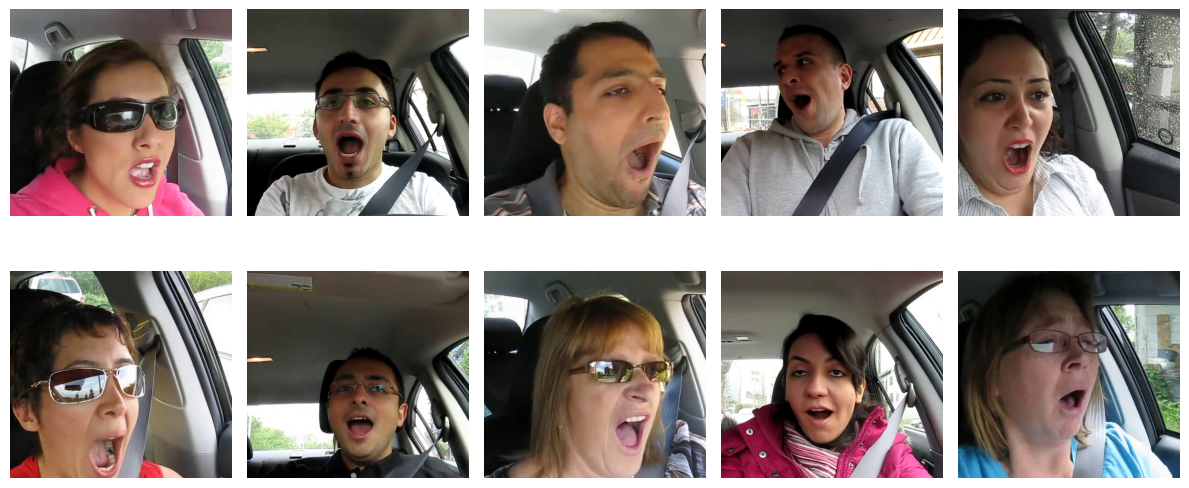

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Directory path
dir_path = 'data/train/yawn/'

# Get a list of all image filenames in the directory
image_files = os.listdir(dir_path)

# Randomly select 10 image filenames
selected_images = np.random.choice(image_files, size=10, replace=False)

# Create a subplot of 10 images
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

# Loop over the selected images and crop them
for i, image_file in enumerate(selected_images):
    # Load the image
    img_path = os.path.join(dir_path, image_file)
    img = cv2.imread(img_path)
    
    # Crop the image
    cropped_image = img[0:400, 120:550]
    
    # Convert BGR to RGB format for plotting
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    
    # Display the cropped image in the subplot
    axs[i].imshow(cropped_image)
    axs[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Custom Drosiness Dataset

In [3]:
class DrowsyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)

    def __len__(self):
        length = 0
        for c in self.classes:
            class_dir = os.path.join(self.root_dir, c)
            length += len(os.listdir(class_dir))
        return length

    def __getitem__(self, idx):
        

        img_label = None
        class_idx = 0

        for c in self.classes:
            class_dir = os.path.join(self.root_dir, c)
            if idx < len(os.listdir(class_dir)):
                img_name = os.listdir(class_dir)[idx]
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_label = c
                break
            else:
                idx -= len(os.listdir(class_dir))
                class_idx += 1

        # Convert image to PIL format
        pil_img = Image.fromarray(img)

        if self.transform:
            pil_img = self.transform(pil_img)

        
        if img_label in ["yawn", "no_yawn"]:
        
            # Crop the image
            cropped_image = img[0:400, 120:550]

            # Convert the image to PIL format and apply the transform
            pil_img = transforms.ToPILImage()(cropped_image)
            
            if self.transform:
                pil_img = self.transform(pil_img)
            else:
                
                pil_img = None
                class_idx = None

        return pil_img, class_idx



In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

# Define transforms to be applied on the images
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create instances of the custom dataset class for train, validation and test data
dataset = DrowsyDataset('data/train/', data_transforms)



In [5]:
from sklearn.model_selection import train_test_split

# # Get the labels from the dataset
# labels = np.array([label for _, label in dataset])

# Split the dataset into train and test sets, stratified by the target variable
train_data, test_data = train_test_split(dataset, test_size=0.2,  random_state=42)

# Print the sizes of train and test sets
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))



Train set size: 2320
Test set size: 580


In [6]:
# Define batch size for DataLoader
batch_size = 32

# Create DataLoader instances for train, validation and test data
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

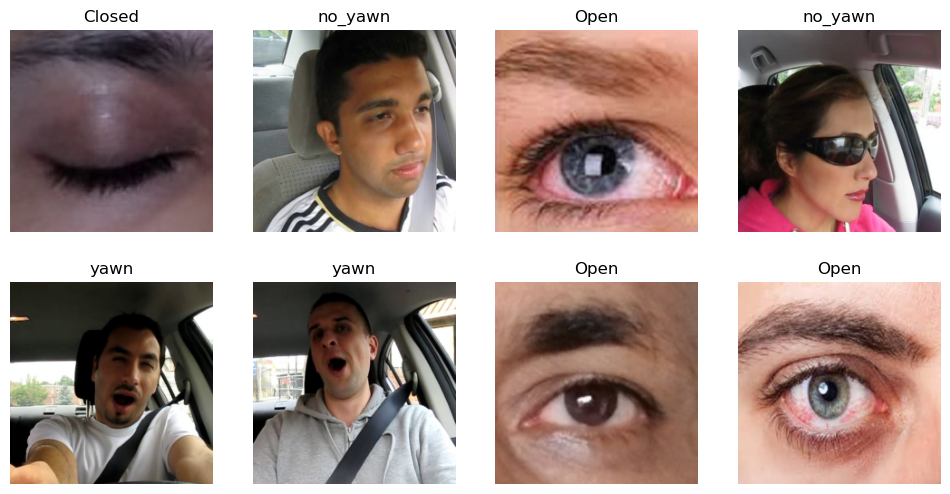

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and their corresponding labels
images, labels = next(iter(train_loader))

# Convert images to numpy arrays and unnormalize them
image_array = images.numpy()
image_array = np.transpose(image_array, (0, 2, 3, 1))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_array = std * image_array + mean
image_array = np.clip(image_array, 0, 1)

# Define a list of class names
class_names = dataset.classes

# Plot the images with their corresponding labels
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i in range(8):
    img = image_array[i]
    label = class_names[labels[i]]
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()


## **AlexNet Modelling**

In [9]:
import torch.optim as optim
from torchvision.models import vgg16

# Load the VGG16 model
vgg16_model = vgg16(pretrained=True)

# Replace the last fully connected layer with a new one for the number of classes in your dataset
num_classes = len(dataset.classes)
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, num_classes)



In [10]:
from tqdm import tqdm_notebook as tqdm

In [12]:
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Update progress bar description
        progress_bar.set_postfix(loss=f"{running_loss / (len(progress_bar) * batch_size):.4f}")

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

C:\Users\adity\AppData\Local\Temp\ipykernel_9916\96482170.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)


Epoch 1/5:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2861


Epoch 2/5:   0%|          | 0/73 [00:01<?, ?it/s]

Epoch [2/5], Loss: 0.0241


Epoch 3/5:   0%|          | 0/73 [00:01<?, ?it/s]

Epoch [3/5], Loss: 0.0105


Epoch 4/5:   0%|          | 0/73 [00:01<?, ?it/s]

KeyboardInterrupt: 

### **Save Model**

In [ ]:
# Save the model
torch.save(vgg16_model.state_dict(), 'models/vgg16_model.pth')


## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the model to evaluation mode
vgg16_model.eval()

# Initialize lists to store the predicted labels and true labels
predicted_labels = []
true_labels = []

# Iterate over the test dataset and make predictions
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass to get the predicted probabilities
    outputs = vgg16_model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Append the predicted labels and true labels to the lists
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Compute the test metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the test metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9827586206896551
Precision: 0.9835442655037794
Recall: 0.9827586206896551
F1 Score: 0.982742774793938


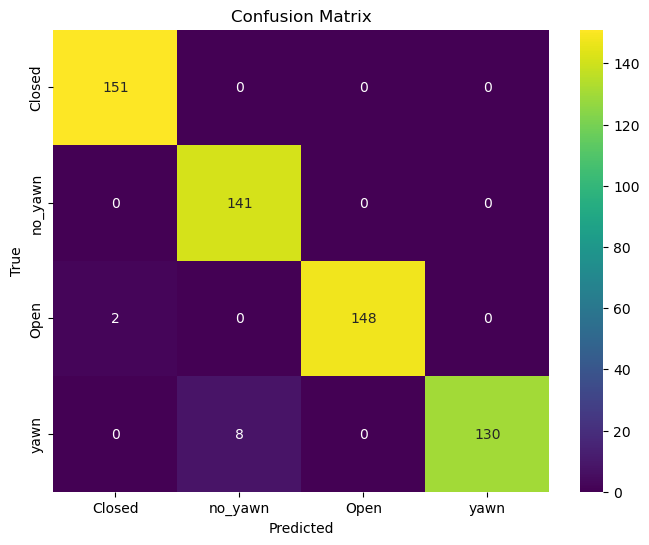

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## **Incorrect Predictions Subplot**

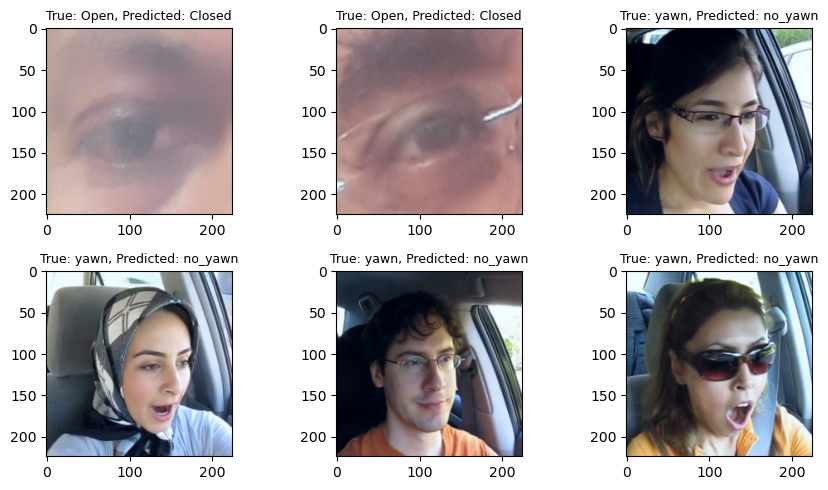

In [ ]:
# Set the model to evaluation mode
vgg16_model.eval()

# Initialize a counter for the subplot
subplot_count = 0

# Create a subplot with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(9, 5))

# Create a list of class labels
class_labels = ['Closed', 'no_yawn', 'Open', 'yawn']

# Iterate over the test dataset
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass to get the predicted probabilities
    outputs = vgg16_model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Compare predicted labels with true labels
    incorrect_predictions = (predicted != labels)
    
    # Iterate over the batch and plot the wrongly predicted images
    for i in range(images.size(0)):
        if incorrect_predictions[i]:
            # Convert the image tensor to NumPy array and transpose the dimensions
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            
            # Reverse the normalization to obtain the original image
            img = img * 0.225 + 0.45
            
            # Clip the pixel values to the range [0, 1]
            img = np.clip(img, 0, 1)
            
            # Calculate the subplot indices
            row_index = subplot_count // 3
            col_index = subplot_count % 3
            
            # Plot the image in the corresponding subplot
            axs[row_index, col_index].imshow(img)
            
            # Get the true label and predicted label text
            true_label = class_labels[labels[i].item()]
            predicted_label = class_labels[predicted[i].item()]
            
            axs[row_index, col_index].set_title(f"True: {true_label}, Predicted: {predicted_label}", fontsize=9)
            
            # Increment the subplot count
            subplot_count += 1
            
            # Break the loop if 6 images have been plotted
            if subplot_count >= 6:
                break
    
    # Break the loop if 6 images have been plotted
    if subplot_count >= 6:
        break

# Remove any unused subplots
if subplot_count < 6:
    for i in range(subplot_count, 6):
        row_index = i // 3
        col_index = i % 3
        axs[row_index, col_index].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
dataset.classes

['Closed', 'no_yawn', 'Open', 'yawn']